In [1]:
using NPZ
using Plots
using PaddedViews
using ProgressMeter
using LinearAlgebra
using TimerOutputs
using BenchmarkTools
using Profile
using ProfileSVG

# Wczytanie danych

In [2]:
train_dict = npzread("KMNIST/kmnist-train-imgs.npz")
train_labels = npzread("KMNIST/kmnist-train-labels.npz")
test_dict = npzread("KMNIST/kmnist-test-imgs.npz")
test_labels = npzread("KMNIST/kmnist-test-labels.npz");

In [3]:
const labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"];

In [4]:
const train_y = convert(Vector{Int64}, train_labels["arr_0"])
const test_y = convert(Vector{Int64}, test_labels["arr_0"])

train = convert(Array{Float32}, train_dict["arr_0"])/255
train = permutedims(train, (2,3,1))
const train_x = reshape(train, (28,28,1,60000))

test = convert(Array{Float32}, test_dict["arr_0"])/255
test = permutedims(test, (2,3,1))
const test_x = reshape(test, (28,28,1,10000));

println("Train images:\t", size(train_x), "\t\t labels: ", size(train_y))
println("Test images:\t", size(test_x), "\t\t labels: ", size(test_y))

Train images:	(28, 28, 1, 60000)		 labels: (60000,)
Test images:	(28, 28, 1, 10000)		 labels: (10000,)


# Graf obliczeniowy -- węzły

In [5]:
abstract type Node end
abstract type Operator <: Node end

struct Variable{N} <: Node
    name::String
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    v₁::Array{Float64, N}
    v₂::Array{Float64, N}
    v̂₁::Array{Float64, N}
    v̂₂::Array{Float64, N}
    Variable(N, output; name = "?") = new{N}(name, output, zeros(size(output)), zeros(size(output)), zeros(size(output)), zeros(size(output)), zeros(size(output)))
end

struct NodeOperator{F, N} <: Operator
    name::String
    inputs::Vector{Node}
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    NodeOperator(fun, inputs...; name = "?", shape=(1,1,1)) = new{typeof(fun), length(shape)}(name, [inputs...], zeros(shape), zeros(shape))
end

struct ConvOperator{F, N} <: Operator
    name::String
    inputs::Vector{Node}
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    x_vectorized::Array{Float64, 3}
    x̂_vectorized::Array{Float64, 2}
    mul_res::Array{Float64, 2}
    x̂::Array{Float64, 3}
    g_pad_vect::Array{Float64, 3}
    dk::Array{Float64, 2}
    dx_vect::Array{Float64, 2}
    dx::Array{Float64, 3}
    ConvOperator(fun, x_vect, x̂_vect, mul_res, x̂, g_pad_vect, dk, dx_vect, dx, inputs...; name = "?", shape=(1,1,1)) = new{typeof(fun), length(shape)}(name, [inputs...], zeros(shape), zeros(shape), x_vect, x̂_vect, mul_res, x̂, g_pad_vect, dk, dx_vect, dx)
end

In [6]:
import Base: show, summary
show(io::IO, x::NodeOperator{F}) where {F} = print(io, "op ", "(", F, ")");
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 406 methods)

# Graf obliczeniowy -- funkcje

### Tworzenie grafu

In [7]:
function visit(node::Node, visited::Set, order::Vector)
    if node ∉ visited
        push!(visited, node)
        push!(order, node)
    end
end

function visit(node::Operator, visited::Set, order::Vector)
    if node ∉ visited
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(visited, node)
        push!(order, node)
    end
end


function create_graph(root::Node)
    visited = Set()
    order = Vector()
    visit(root, visited, order)
    return order
end

create_graph (generic function with 1 method)

### Przejście w przód z zerowaniem gradientu

In [8]:
zero_gradient!(node::Node) = fill!(node.gradient, 0)

compute!(node::Variable) = nothing
compute!(node::Operator) = node.output .= forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector{Node})::Float64
    for node in order
        compute!(node)
        zero_gradient!(node)
    end
    
    return last(order).output[1]
end    

forward! (generic function with 1 method)

### Przejście w tył

In [9]:
update!(node::Node, gradient) = if isempty(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed = 1.0)
    result = last(order)
    result.gradient .= [seed]
    
    for node in reverse(order)
        backward!(node)
    end
end

backward!(node::Variable) = nothing

function backward!(node::Operator)
    gradients = backward(node, [input.output for input in node.inputs]..., node.gradient)
    for (input, gradient) in zip(node.inputs, gradients)
        @timeit to "update" update!(input, gradient)
    end
end

backward! (generic function with 3 methods)

# Sieć i warstwy

### Definicja struktur parametrów

In [10]:
struct ConvParams
    kernels::Variable{2}
    bias::Variable{2}
end

struct DenseParams
    weights::Variable{2}
    bias::Variable{1}
end

struct CNNParams
    conv1::ConvParams
    conv2::ConvParams
    dense1::DenseParams
    dense2::DenseParams
end

### Warstwa konwolucyjna

In [11]:
function im2col!(img, n, out)
    rows, cols, ch = size(img)
    no_blocks = rows - n + 1
    for c in 1:ch
        for j in 1:no_blocks
            for i in 1:no_blocks
                @views block = img[i:i+n-1, j:j+n-1, c]
                for k in 1:n*n
                      out[k,(j-1)*no_blocks+i, c] = block[k]
                end
            end
        end
    end
end

im2col! (generic function with 1 method)

In [12]:
function col2im!(x, out)
    rows, cols = size(x)
    n = size(out)[1]
    for j in 1:cols
        for i in 1:rows
            out[mod(j-1, n)+1, ceil(Int, j/n), i] = x[i, j]
        end
    end
end

col2im! (generic function with 1 method)

In [13]:
conv_layer(x::Node, x_vect, x̂_vect, mul_res, x̂, g_pad_vect, dk, dx_vect, dx, k::Node, b::Node, shape) =
ConvOperator(conv_layer, x_vect, x̂_vect, mul_res, x̂, g_pad_vect, dk, dx_vect, dx, name="conv", shape=shape, x, k, b)

tt = TimerOutput()

@timeit to "conv forward" forward(node::ConvOperator{typeof(conv_layer)}, x, k, b) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = node.x_vectorized
    im2col!(x, 5, x_vectorized)
    
    x̂_vectorized = node.x̂_vectorized
    fill!(x̂_vectorized, 0)
    res = node.mul_res

    @simd for i in 1:x_size[3]
        @inbounds @views x̂_vectorized[:, :] += mul!(res, k, x_vectorized[:, :, i])
    end
    
    x̂_vectorized .+= b

    x̂ = node.x̂
    col2im!(x̂_vectorized, x̂)
    
    return x̂
end


@timeit to "conv backward" backward(node::ConvOperator{typeof(conv_layer)}, x, k, b, g) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = node.x_vectorized
                
    im2col!(x, 5, x_vectorized)
    
    g_vectorized = reshape(g, size(g)[1]^2, size(g)[3])
    
    dk = node.dk
    
    @views dk = mul!(dk, g_vectorized', sum(x_vectorized, dims=3)[:,:,1]')
    
    g_transposed = permutedims(g_vectorized, (2,1))
    db = sum(g_transposed, dims=1)
    
    g_size = size(g)
    g_padded = PaddedView(0, g, (1:(g_size[1]+8), 1:(g_size[1]+8), 1:g_size[3]), (5:(g_size[1]+4), 5:(g_size[1]+4), 1:g_size[3]))
    g_pad_vect = node.g_pad_vect
    
    im2col!(g_padded, 5, g_pad_vect)
    k_reversed = reverse(k, dims=2)
    
    dx_vect = node.dx_vect
    fill!(dx_vect, 0)

    @simd for i in 1:g_size[3]
        @inbounds @views dx_vect .+= k_reversed * g_pad_vect[:, :, i]
    end
    
    dx_vect = sum(dx_vect, dims=1)
    
    dx = node.dx
    dx = repeat(reshape(dx_vect, (x_size[1], x_size[1])), 1, 1, x_size[3])
    
    return tuple(dx, dk, db)
end

backward (generic function with 1 method)

In [94]:
A = rand(4,3)
B = zeros(1,3)
@btime B = sum(A, dims=1)

  84.424 ns (1 allocation: 80 bytes)


1×3 Matrix{Float64}:
 1.17601  2.17751  1.36467

In [284]:
A = rand(4,3)
@btime sum(A', dims=1)

  1.060 μs (7 allocations: 272 bytes)


1×4 Matrix{Float64}:
 1.76648  1.48263  1.75533  1.23318

In [193]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
backward(conv_layer(x, cnn_params.conv1.kernels, cnn_params.conv1.bias, (24,24,20)), x.output, k, b, g);
show(tt)
reset_timer!(tt);

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            269ms /   0.2%           1.68MiB /  27.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 x_vect reshape             1    342μs   54.8%   342μs    198KiB   41.4%   198KiB
 dk comp                    1    177μs   28.3%   177μs    226KiB   47.2%   226KiB
 dx comp                    1   67.6μs   10.8%  67.6μs   24.8KiB    5.2%  24.8KiB
 db sum                     1   16.7μs    2.7%  16.7μs   4.81KiB    1.0%  4.81KiB
 dx set                     1   9.70μs    1.6%  9.70μs   12.4KiB    2.6%  12.4KiB
 dk repeat                  1   5.30μs    0.8%  5.30μs   6.47KiB    1.4%  6.47KiB
 dx sum        

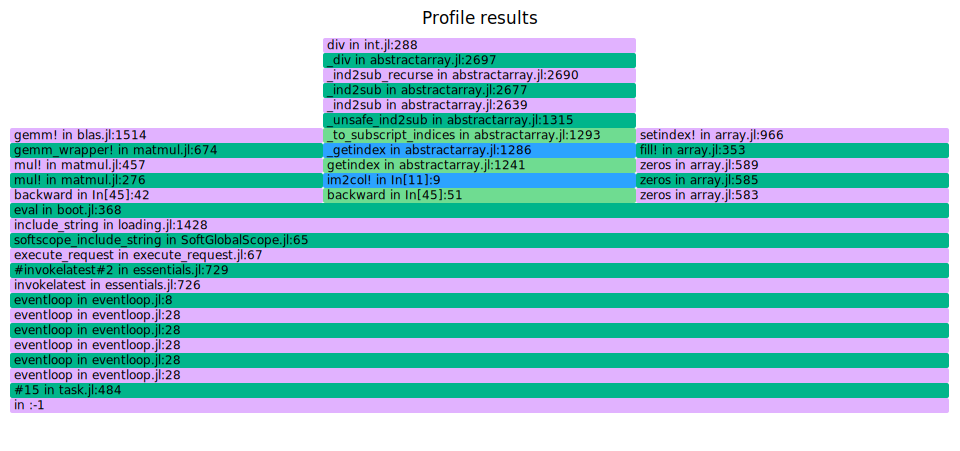

In [75]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
@profile backward(conv_layer(
        x,
        zeros(25, 24^2, 1),
        zeros(20, 24^2),
        zeros(20, 24^2),
        zeros(24, 24, 20),
        cnn_params.conv1.kernels,
        cnn_params.conv1.bias,
        (24,24,20)
    ), x.output, k, b, g)
ProfileSVG.view()

In [378]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
backward(conv_layer(x, cnn_params.conv1.kernels, cnn_params.conv1.bias, (24,24,20)), x.output, k, b, g);
show(tt)
reset_timer!(tt);

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            184ms /   0.3%            968KiB /  17.4%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 g_pad_vect im2col          1    243μs   52.2%   243μs     32.0B    0.0%    32.0B
 dk comp                    1    100μs   21.5%   100μs    113KiB   67.0%   113KiB
 x_vect im2col              1   54.8μs   11.8%  54.8μs     32.0B    0.0%    32.0B
 dx comp                    1   39.1μs    8.4%  39.1μs   24.8KiB   14.7%  24.8KiB
 db sum                     1   15.2μs    3.3%  15.2μs   4.81KiB    2.9%  4.81KiB
 dx sum                     1   5.60μs    1.2%  5.60μs   6.28KiB    3.7%  6.28KiB
 dk repeat     

In [135]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
forward(conv_layer(x, cnn_params.conv1.kernels, cnn_params.conv1.bias, (24,24,20)), x.output, k, b);
show(tt)
reset_timer!(tt);

 ───────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
     Tot / % measured:         295ms /   0.1%            526KiB /  31.0%    

 Section          ncalls     time    %tot     avg     alloc    %tot      avg
 ───────────────────────────────────────────────────────────────────────────
 conv forward          1    166μs  100.0%   166μs    163KiB  100.0%   163KiB
   x_vect set          1   65.9μs   39.8%  65.9μs    113KiB   69.0%   113KiB
   x̂_vect comp         1   22.9μs   13.8%  22.9μs   9.16KiB    5.6%  9.16KiB
   x̂ reshape           1   5.50μs    3.3%  5.50μs   9.47KiB    5.8%  9.47KiB
   x̂_vect add b        1   3.00μs    1.8%  3.00μs     32.0B    0.0%    32.0B
   x̂ set               1   3.00μs    1.8%  3.00μs   9.16KiB    5.6%  9.16KiB
   x̂_vect set          1   1.40μs    0.8%  1.40μs   9.16KiB    5.6%  9

In [185]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
forward(conv_layer(x, cnn_params.conv1.kernels, cnn_params.conv1.bias, (24,24,20)), x.output, k, b);
show(tt)
reset_timer!(tt);

 ────────────────────────────────────────────────────────────────────────────
                                    Time                    Allocations      
                           ───────────────────────   ────────────────────────
     Tot / % measured:          1.05s /   0.0%            524KiB /  29.5%    

 Section           ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────
 conv forward           1    165μs  100.0%   165μs    154KiB  100.0%   154KiB
   x_vect set           1   66.0μs   40.0%  66.0μs    113KiB   72.9%   113KiB
   x_vect im2col        1   54.4μs   33.0%  54.4μs     32.0B    0.0%    32.0B
   x̂_vect comp          1   20.0μs   12.1%  20.0μs   9.16KiB    5.9%  9.16KiB
   x̂ col2im             1   9.40μs    5.7%  9.40μs     32.0B    0.0%    32.0B
   x̂_vect add b         1   2.80μs    1.7%  2.80μs     32.0B    0.0%    32.0B
   x̂_vect set           1   1.40μs    0.8%  1.40μs   9.16Ki

In [143]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
k = [-3 -1 0 1 3 -3 -1 0 1 3 -4 -2 0 2 4 -3 -1 0 1 3 -3 -1 0 1 3; 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25 1/25]
b = zeros(1,24*24)
g = rand(Float64, 24,24,2)
forward(conv_layer(x, cnn_params.conv1.kernels, cnn_params.conv1.bias, (24,24,20)), x.output, k, b);
show(tt)
reset_timer!(tt);

 ─────────────────────────────────────────────────────────────────────────────
                                     Time                    Allocations      
                            ───────────────────────   ────────────────────────
      Tot / % measured:          348ms /   0.1%            732KiB /  49.5%    

 Section            ncalls     time    %tot     avg     alloc    %tot      avg
 ─────────────────────────────────────────────────────────────────────────────
 conv forward            1    262μs  100.0%   262μs    362KiB  100.0%   362KiB
   x_vect set            1    127μs   48.5%   127μs    113KiB   31.1%   113KiB
   x_vect reshape        1   89.9μs   34.2%  89.9μs    198KiB   54.7%   198KiB
   x̂_vect comp           1   19.9μs    7.6%  19.9μs   18.3KiB    5.1%  18.3KiB
   x̂ reshape             1   5.60μs    2.1%  5.60μs   9.47KiB    2.6%  9.47KiB
   x̂_vect set            1   4.10μs    1.6%  4.10μs   9.16KiB    2.5%  9.16KiB
   x̂_vect add b          1   2.60μs    1.0%  2.

### Warstwa maxpool

In [14]:
maxpool_layer(x::Node, shape) = NodeOperator(maxpool_layer, name="maxpool", shape=shape, x)

@timeit to "maxpool forward" forward(::NodeOperator{typeof(maxpool_layer)}, x) = let
    n = floor(Int, size(x)[1]/2) # new size
    x̂ = zeros(n, n, size(x)[3])
    s = 2 # stride
    
    @simd for r in 1:n
        for c in 1:n
            @inbounds @views x̂[r, c, :] = maximum(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2), init=-1.0)
        end
    end
    
    return x̂
end

@timeit to "maxpool backward" backward(::NodeOperator{typeof(maxpool_layer)}, x, g) = let
    n = floor(Int, size(x)[1]/2) # new size
    s = 2 # stride
    x̂ = zeros(size(x))
    
    @simd for r in 1:n
        for c in 1:n
            @inbounds @views idx = argmax(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
            @inbounds @views x̂[(r*s-1):(r*s), (c*s-1):(c*s), :][idx] = g[r, c, :]
        end
    end
    return tuple(x̂)
end

backward (generic function with 2 methods)

### Warstwa flatten

In [15]:
flatten(x::Node, shape) = NodeOperator(flatten, name="flatten", shape=shape, x)

@timeit to "flatten forward" forward(::NodeOperator{typeof(flatten)}, x) = let
    return reshape(x, size(x)[1]*size(x)[2]*size(x)[3])
end

@timeit to "flatten backward" backward(::NodeOperator{typeof(flatten)}, x, g) = let
    return tuple(reshape(g, size(x)))
end

backward (generic function with 3 methods)

### Warstwa gęsta

In [16]:
dense_layer(x::Node, w::Node, b::Node, shape) = NodeOperator(dense_layer, name="dense", shape=shape, x, w, b)

@timeit to "dense forward" forward(::NodeOperator{typeof(dense_layer)}, x, w, b) = let
    return w * x + b
end

@timeit to "dense backward" backward(::NodeOperator{typeof(dense_layer)}, x, w, b, g) = let
    return tuple(w' * g, g * x', g)
end

backward (generic function with 4 methods)

### ReLU

In [17]:
relu(x::Node, shape) = NodeOperator(relu, name="relu", shape=shape, x)

@timeit to "relu forward" forward(::NodeOperator{typeof(relu)}, x) = let
    return max.(x, 0)
end

@timeit to "relu backward" backward(::NodeOperator{typeof(relu)}, x, g) = let
    id_max = findall(a -> a > 0, x)
    x̂ = zeros(Float64, size(x))
    x̂[id_max] = g[id_max]
    return tuple(x̂)
end

backward (generic function with 5 methods)

### Softmax

In [18]:
softmax(x::Node, shape) = NodeOperator(softmax, name="softmax", shape=shape, x)

@timeit to "softmax forward" forward(::NodeOperator{typeof(softmax)}, x) = let
    return exp.(x) ./ sum(exp.(x))
end

@timeit to "softmax backward" backward(node::NodeOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 6 methods)

### Funkcja straty -- cross entropy loss

In [19]:
cross_entropy_loss(ŷ::Node, y::Node, shape) = NodeOperator(cross_entropy_loss, name="cross_entropy_loss", shape=shape,  ŷ, y)

@timeit to "cross_entropy_loss forward" forward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y) = let
    return [-log(ŷ[floor(Int, y[1]+1)])]
end

@timeit to "cross_entropy_loss backward" backward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y, g) = let
    x = zeros(10)
    id = floor(Int, y[1]) + 1
    x[id] = -1 / ŷ[id] * g[1]
    return tuple(x, [0.0])
end

backward (generic function with 7 methods)

## Struktura sieci

In [20]:
#g_pad_vect, dk, dx_vect, dx

function my_cnn(x::Variable{3}, y::Variable{1}, params::CNNParams)
    x₁ = conv_layer(
        x,
        zeros(25, 24^2, 1),
        zeros(20, 24^2),
        zeros(20, 24^2),
        zeros(24, 24, 20),
        zeros(25, 28^2, 20),
        zeros(20, 25),
        zeros(20, 28^2),
        zeros(28,28,1),
        params.conv1.kernels,
        params.conv1.bias,
        (24,24,20),
    )
    x₂ = relu(x₁, (24,24,20))
    x₃ = maxpool_layer(x₂, (12,12,20))
    x₄ = conv_layer(
        x₃,
        zeros(25, 8^2, 20),
        zeros(50, 8^2),
        zeros(50, 8^2),
        zeros(8, 8, 50),
        zeros(25, 12^2, 50),
        zeros(50, 25),
        zeros(50, 12^2),
        zeros(12,12,20),
        params.conv2.kernels,
        params.conv2.bias,
        (8,8,50)
    )
    x₅ = relu(x₄, (8,8,50))
    x₆ = maxpool_layer(x₅, (4,4,50))
    
    x₇ = flatten(x₆, (800))
    
    x₈ = dense_layer(x₇, params.dense1.weights, params.dense1.bias, (500))
    x₉ = dense_layer(x₈, params.dense2.weights, params.dense2.bias, (10))
    
    ŷ = softmax(x₉, (10))
    
    loss = cross_entropy_loss(ŷ, y, (1))
    
    return create_graph(loss)
end

my_cnn (generic function with 1 method)

### Inicjalizacja wag

In [21]:
function he_weights_init(prev, shape...)
    std = sqrt(2.0/prev)
    weights = rand(Float64, shape) .*2 .-1
    return weights .* std
end

he_weights_init (generic function with 1 method)

### Optymalizator -- ADAM

In [38]:
mutable struct Adam
    α::Float64
    ε::Float64
    m₁::Float64
    m₂::Float64
    k::Int64
    Adam(α=0.001, m₁=0.9, m₂=0.999, ε=1e-8) = new(α, ε, m₁, m₂, 1)
end

In [24]:
function update_weights!(graph, M::Adam)
    for node in graph
        if typeof(node) == Variable{1} || typeof(node) == Variable{2} || typeof(node) == Variable{3}
            update_weights_N!(node, M)
        end
    end
    M.k += 1
end



function update_weights_N!(node::Variable{T}, M::Adam) where T
    g = node.gradient
    v₁ = node.v₁
    v₂ = node.v₂
    v̂₁ = node.v̂₁
    v̂₂ = node.v̂₂
    m₁, m₂, k, α, ε = M.m₁, M.m₂, M.k, M.α, M.ε
    v₁ .= @. m₁ * v₁ + (1.0 - m₁) * g
    v₂ .= @. m₂ * v₂ + (1.0 - m₂) * (g .* g)

    v̂₁ .= v₁ ./ (1.0 - m₁^k)
    v̂₂ .= v₂ ./ (1.0 - m₂^k)

    node.output .-= @. α*v̂₁ / (sqrt(v̂₂) + ε)
    
    nothing
end

update_weights_N! (generic function with 1 method)

### Inicjalizacja parametrów sieci

In [42]:
conv1 = ConvParams(
    Variable(2, he_weights_init(28*28, 20,25), name="k1"),
    Variable(2, zeros(1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(2, he_weights_init(12*12*20, 50,25), name="k2"),
    Variable(2, zeros(1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(2, he_weights_init(4*4*50, 500,800), name="w3"),
    Variable(1, zeros(500), name="b3")
)
dense2 = DenseParams(
    Variable(2, he_weights_init(500, 10,500), name="w4"),
    Variable(1, zeros(10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [26]:
function validate(x, y, graph, val_x, val_y, no_val, count_class, acc_class, e)::Tuple{Float64, Array{Float64, 2}, Float64}
    correct_val = 0
    correct_class = zeros(10)
    loss = 0
    
    @inbounds @simd for i in 1:no_val
        x.output .= val_x[:,:,:,i]
        y.output .= [val_y[i]]
        loss += forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (val_y[i] + 1)
            correct_val += 1
            correct_class[pred] += 1
        end
    end
    
    acc_val = correct_val/no_val
    acc_class[:, e] = correct_class ./ count_class
    
    return (acc_val, acc_class, loss/no_val)
end

validate (generic function with 1 method)

In [30]:
to = TimerOutput()

function train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y, no_train)
    epochs = 10

    ids = rand(1:60000, no_train)
    data_x = train_x[:,:,:,ids]
    data_y = train_y[ids]

    no_val = 1000
    ids_val = rand(1:10000, no_val)
    val_x = test_x[:,:,:,ids_val]
    val_y = test_y[ids_val]


    loss::Float64 = 0.0
    pred::UInt8 = 0
    losses = zeros(epochs)
    count_class = [count(==(i), val_y) for i in 0:9]
    acc = zeros(epochs)
    acc_class::Array{Float64, 2} = zeros(10, epochs)
    acc_val::Float64 = 0
    correct_val = 0
    correct = 0 

    for e in 1:epochs
        loss = 0
         correct = 0

        for i in 1:no_train
            x.output .= data_x[:,:,:,i]
            y.output .= [data_y[i]]

            @timeit to "forward" loss += forward!(graph)
            prob::NodeOperator{typeof(softmax), 1} = graph[19]
            pred = argmax(prob.output)
            if pred == (data_y[i] + 1)
                correct += 1
            end

            @timeit to "backward" backward!(graph)

            @timeit to "update weights" update_weights!(graph, adam)
        end

        losses[e] = loss/no_train
        acc[e] = correct/no_train
        acc_val, acc_class, val_loss = validate(x, y, graph, val_x, val_y, no_val, count_class, acc_class, e)

        println("Epoch: ", e, "\tAverage loss: ", round(losses[e], digits=3), "\tAverage acc: ", round(acc[e],digits=3), "\tAverage val acc: ", round(acc_val, digits=3), "\tVal loss: ", val_loss)
    end

    println(round.(acc_class[:, epochs], digits=3))
    
    return graph
end

train_cnn (generic function with 1 method)

In [43]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y, 1000);

Epoch: 1	Average loss: 1.391	Average acc: 0.525	Average val acc: 0.503	Val loss: 1.555347806804184
Epoch: 2	Average loss: 1.094	Average acc: 0.627	Average val acc: 0.452	Val loss: 1.7219994542259294
Epoch: 3	Average loss: 0.956	Average acc: 0.687	Average val acc: 0.51	Val loss: 1.8060795665491323
Epoch: 4	Average loss: 0.976	Average acc: 0.696	Average val acc: 0.533	Val loss: 1.8405097012525327
Epoch: 5	Average loss: 0.834	Average acc: 0.74	Average val acc: 0.542	Val loss: 1.7928752174929652
Epoch: 6	Average loss: 0.905	Average acc: 0.726	Average val acc: 0.516	Val loss: 1.9281018950987916
Epoch: 7	Average loss: 0.892	Average acc: 0.742	Average val acc: 0.464	Val loss: 2.061614315839663
Epoch: 8	Average loss: 0.814	Average acc: 0.749	Average val acc: 0.521	Val loss: 2.3568290585345535
Epoch: 9	Average loss: 0.91	Average acc: 0.74	Average val acc: 0.549	Val loss: 2.1589857695247905
Epoch: 10	Average loss: 0.875	Average acc: 0.738	Average val acc: 0.552	Val loss: 2.3168659883267977
[0.59

In [41]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y, 1000);

Epoch: 1	Average loss: 1.455	Average acc: 0.517	Average val acc: 0.506	Val loss: 1.5312895341754613
Epoch: 2	Average loss: 1.12	Average acc: 0.645	Average val acc: 0.557	Val loss: 1.4509648275399525
Epoch: 3	Average loss: 1.175	Average acc: 0.641	Average val acc: 0.535	Val loss: 1.6311514420493534
Epoch: 4	Average loss: 1.117	Average acc: 0.673	Average val acc: 0.48	Val loss: 1.727102075967593
Epoch: 5	Average loss: 1.029	Average acc: 0.683	Average val acc: 0.493	Val loss: 1.567728042915792
Epoch: 6	Average loss: 0.913	Average acc: 0.706	Average val acc: 0.493	Val loss: 1.658995392690539
Epoch: 7	Average loss: 1.027	Average acc: 0.676	Average val acc: 0.503	Val loss: 1.9476019765101915
Epoch: 8	Average loss: 1.066	Average acc: 0.667	Average val acc: 0.544	Val loss: 1.9186096624452569
Epoch: 9	Average loss: 0.96	Average acc: 0.718	Average val acc: 0.481	Val loss: 1.8160599921253282
Epoch: 10	Average loss: 0.829	Average acc: 0.727	Average val acc: 0.539	Val loss: 1.761783822402162
[0.545

In [71]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y, 1000);
show(to)
reset_timer!(to)
#@profile train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y, 1000);
#ProfileSVG.view()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:             179s /   8.8%           9.81GiB /  99.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 backward               1.00k    11.0s   69.9%  11.0ms   9.01GiB   92.1%  9.23MiB
   conv backward        2.00k    8.22s   52.2%  4.11ms   5.30GiB   54.2%  2.72MiB
   dense backward       2.00k    1.09s    6.9%   546μs   3.03GiB   30.9%  1.55MiB
   update               20.0k    758ms    4.8%  37.9μs   8.38MiB    0.1%     439B
   maxpool backward     2.00k    349ms    2.2%   174μs    271MiB    2.7%   139KiB
   relu backward        2.00k    181ms    1.2%  90.6μs    392MiB    3.9%   201KiB
   softmax back

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      419μs /   0.0%           26.1KiB /   0.0%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 ────────────────────────────────────────────────────────────────────

In [53]:
reset_timer!(to)

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      362μs /   0.0%           3.35KiB /   0.0%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 ────────────────────────────────────────────────────────────────────

In [28]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 100

times = zeros(20)
memory = zeros(20)

num = 1
for i in 2000:1000:10000
    x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
    y::Variable{1} = Variable(1, [train_x[1]], name="y")
    graph::Vector{Node} = my_cnn(x, y, cnn_params)
    adam = Adam()
    b = @benchmark train_cnn($x, $y, $graph, $adam, $train_x, $train_y, $test_x, $test_y, $i) samples = 2 evals = 1 seconds = 100
    b = mean(b)
    times[num] = b.time * 10e-10 
    memory[num] = b.memory * 9.31*10e-11
    println(i)
    println(times[num])
    println(memory[num])
    num += 1
end

println(times)
println(memory)

Epoch: 1	Average loss: 0.936	Average acc: 0.73	Average val acc: 
Epoch: 2	Average loss: 0.985	Average acc: 0.702	Average val acc: 
Epoch: 3	Average loss: 0.955	Average acc: 0.706	Average val acc: 
Epoch: 1	Average loss: 1.154	Average acc: 0.665	Average val acc: 
Epoch: 2	Average loss: 0.983	Average acc: 0.7	Average val acc: 
Epoch: 3	Average loss: 0.987	Average acc: 0.702	Average val acc: 
2000
289.1782114
58.638765144064
Epoch: 1	Average loss: 1.033	Average acc: 0.688	Average val acc: 
Epoch: 2	Average loss: 1.081	Average acc: 0.673	Average val acc: 
Epoch: 3	Average loss: 1.067	Average acc: 0.677	Average val acc: 
Epoch: 1	Average loss: 1.131	Average acc: 0.661	Average val acc: 
Epoch: 2	Average loss: 1.112	Average acc: 0.671	Average val acc: 
Epoch: 3	Average loss: 1.085	Average acc: 0.678	Average val acc: 
3000
451.50334430000004
87.92008430990401
Epoch: 1	Average loss: 1.104	Average acc: 0.675	Average val acc: 
Epoch: 2	Average loss: 1.192	Average acc: 0.639	Average val acc: 
Epoc

LoadError: InterruptException:

1

In [30]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 200

times = zeros(20)
memory = zeros(20)

num = 1
for i in 100:100:2000
    x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
    y::Variable{1} = Variable(1, [train_x[1]], name="y")
    graph::Vector{Node} = my_cnn(x, y, cnn_params)
    adam = Adam()
    b = @benchmark train_cnn($x, $y, $graph, $adam, $train_x, $train_y, $test_x, $test_y, $i) samples = 2 evals = 1 seconds = 100
    b = mean(b)
    times[num] = b.time * 10e-10 
    memory[num] = b.memory * 9.31*10e-11
    num += 1
end

println(times)
println(memory)

Epoch: 1	Average loss: 2.136	Average acc: 0.28	Average val acc: 
Epoch: 2	Average loss: 1.439	Average acc: 0.54	Average val acc: 
Epoch: 3	Average loss: 1.019	Average acc: 0.63	Average val acc: 
Epoch: 1	Average loss: 1.718	Average acc: 0.58	Average val acc: 
Epoch: 2	Average loss: 1.162	Average acc: 0.68	Average val acc: 
Epoch: 3	Average loss: 0.82	Average acc: 0.77	Average val acc: 
Epoch: 1	Average loss: 1.716	Average acc: 0.49	Average val acc: 
Epoch: 2	Average loss: 1.141	Average acc: 0.66	Average val acc: 
Epoch: 3	Average loss: 0.796	Average acc: 0.76	Average val acc: 
Epoch: 1	Average loss: 1.15	Average acc: 0.625	Average val acc: 
Epoch: 2	Average loss: 0.885	Average acc: 0.695	Average val acc: 
Epoch: 3	Average loss: 0.674	Average acc: 0.75	Average val acc: 
Epoch: 1	Average loss: 1.238	Average acc: 0.63	Average val acc: 
Epoch: 2	Average loss: 0.797	Average acc: 0.715	Average val acc: 
Epoch: 3	Average loss: 0.742	Average acc: 0.76	Average val acc: 
Epoch: 1	Average loss: 1

In [413]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #300

Epoch: 1	Average loss: 0.826	Average acc: 0.757	Average val acc: 0.59
Epoch: 2	Average loss: 0.624	Average acc: 0.79	Average val acc: 0.58
Epoch: 3	Average loss: 0.537	Average acc: 0.813	Average val acc: 0.61
[0.846, 0.727, 0.75, 0.462, 0.375, 0.692, 0.545, 0.455, 0.5, 0.667]
Epoch: 1	Average loss: 1.207	Average acc: 0.667	Average val acc: 0.5
Epoch: 2	Average loss: 0.85	Average acc: 0.75	Average val acc: 0.52
Epoch: 3	Average loss: 0.882	Average acc: 0.743	Average val acc: 0.5
[0.857, 0.5, 0.0, 0.571, 0.429, 0.5, 0.333, 0.333, 0.786, 0.571]
Epoch: 1	Average loss: 1.194	Average acc: 0.647	Average val acc: 0.51
Epoch: 2	Average loss: 0.872	Average acc: 0.727	Average val acc: 0.55
Epoch: 3	Average loss: 0.622	Average acc: 0.78	Average val acc: 0.59
[0.7, 0.571, 0.5, 0.667, 0.769, 0.462, 0.8, 0.571, 0.556, 0.333]
Epoch: 1	Average loss: 1.266	Average acc: 0.68	Average val acc: 0.48
Epoch: 2	Average loss: 1.031	Average acc: 0.713	Average val acc: 0.49
Epoch: 3	Average loss: 0.952	Average ac

In [31]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000

Epoch: 1	Average loss: 0.873	Average acc: 0.729	Average val acc: 0.64
Epoch: 2	Average loss: 0.789	Average acc: 0.744	Average val acc: 0.55
Epoch: 3	Average loss: 0.833	Average acc: 0.745	Average val acc: 0.61
[0.5, 0.636, 0.8, 0.545, 0.75, 0.889, 0.714, 0.214, 0.889, 0.583]
Epoch: 1	Average loss: 1.128	Average acc: 0.652	Average val acc: 0.57
Epoch: 2	Average loss: 0.977	Average acc: 0.703	Average val acc: 0.59
Epoch: 3	Average loss: 0.873	Average acc: 0.736	Average val acc: 0.52
[0.8, 0.667, 0.333, 0.625, 0.643, 0.727, 0.4, 0.364, 0.538, 0.2]
Epoch: 1	Average loss: 1.116	Average acc: 0.654	Average val acc: 0.48
Epoch: 2	Average loss: 1.047	Average acc: 0.666	Average val acc: 0.45
Epoch: 3	Average loss: 0.958	Average acc: 0.697	Average val acc: 0.45
[0.462, 0.308, 0.188, 0.857, 0.583, 0.571, 0.2, 0.333, 0.667, 0.857]
Epoch: 1	Average loss: 1.126	Average acc: 0.653	Average val acc: 0.59
Epoch: 2	Average loss: 0.979	Average acc: 0.689	Average val acc: 0.59
Epoch: 3	Average loss: 0.947	A

In [33]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000

Epoch: 1	Average loss: 0.952	Average acc: 0.711	Average val acc: 0.62
Epoch: 2	Average loss: 0.967	Average acc: 0.712	Average val acc: 0.57
Epoch: 3	Average loss: 0.887	Average acc: 0.727	Average val acc: 0.55
[0.4, 0.667, 0.5, 0.5, 0.778, 0.444, 0.667, 0.375, 0.636, 0.455]
Epoch: 1	Average loss: 1.2	Average acc: 0.626	Average val acc: 0.47
Epoch: 2	Average loss: 1.058	Average acc: 0.688	Average val acc: 0.46
Epoch: 3	Average loss: 1.057	Average acc: 0.676	Average val acc: 0.48
[0.667, 0.625, 0.444, 0.167, 0.5, 0.571, 0.429, 0.417, 0.429, 0.429]
Epoch: 1	Average loss: 1.356	Average acc: 0.586	Average val acc: 0.56
Epoch: 2	Average loss: 1.198	Average acc: 0.617	Average val acc: 0.53
Epoch: 3	Average loss: 1.094	Average acc: 0.653	Average val acc: 0.56
[0.545, 0.7, 0.083, 0.5, 0.375, 0.875, 0.6, 0.667, 0.636, 0.778]
Epoch: 1	Average loss: 1.294	Average acc: 0.634	Average val acc: 0.42
Epoch: 2	Average loss: 1.206	Average acc: 0.629	Average val acc: 0.46
Epoch: 3	Average loss: 1.109	Aver

In [46]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000

Epoch: 1	Average loss: 1.475	Average acc: 0.508	Average val acc: 0.46
Epoch: 2	Average loss: 1.088	Average acc: 0.649	Average val acc: 0.49
Epoch: 3	Average loss: 0.994	Average acc: 0.678	Average val acc: 0.5
[0.25, 0.615, 0.25, 0.778, 0.333, 0.625, 0.625, 0.727, 0.429, 0.389]
Epoch: 1	Average loss: 1.178	Average acc: 0.637	Average val acc: 0.55
Epoch: 2	Average loss: 1.035	Average acc: 0.667	Average val acc: 0.5
Epoch: 3	Average loss: 0.945	Average acc: 0.702	Average val acc: 0.56
[0.625, 0.75, 0.25, 0.8, 0.583, 0.462, 0.286, 0.667, 0.625, 0.333]
Epoch: 1	Average loss: 1.12	Average acc: 0.656	Average val acc: 0.46
Epoch: 2	Average loss: 0.938	Average acc: 0.715	Average val acc: 0.48
Epoch: 3	Average loss: 0.897	Average acc: 0.714	Average val acc: 0.48
[0.667, 0.455, 0.444, 0.889, 0.154, 0.857, 0.5, 0.625, 0.3, 0.0]
Epoch: 1	Average loss: 1.11	Average acc: 0.665	Average val acc: 0.5
Epoch: 2	Average loss: 0.997	Average acc: 0.694	Average val acc: 0.49
Epoch: 3	Average loss: 0.935	Avera

In [33]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000

Epoch: 1	Average loss: 1.507	Average acc: 0.495	Average val acc: 0.48
Epoch: 2	Average loss: 1.191	Average acc: 0.62	Average val acc: 0.33
Epoch: 3	Average loss: 1.231	Average acc: 0.603	Average val acc: 0.41
[0.4, 0.333, 0.538, 0.333, 0.625, 0.25, 0.438, 0.571, 0.75, 0.0]
Epoch: 1	Average loss: 1.381	Average acc: 0.559	Average val acc: 0.51
Epoch: 2	Average loss: 1.24	Average acc: 0.615	Average val acc: 0.48
Epoch: 3	Average loss: 1.055	Average acc: 0.674	Average val acc: 0.45
[0.562, 0.333, 0.5, 0.5, 0.4, 0.8, 0.333, 0.5, 0.4, 0.182]
Epoch: 1	Average loss: 1.309	Average acc: 0.608	Average val acc: 0.55
Epoch: 2	Average loss: 1.12	Average acc: 0.644	Average val acc: 0.5
Epoch: 3	Average loss: 1.001	Average acc: 0.663	Average val acc: 0.53
[0.917, 0.545, 0.455, 0.3, 0.667, 0.667, 0.714, 0.5, 0.333, 0.273]
Epoch: 1	Average loss: 1.24	Average acc: 0.613	Average val acc: 0.47
Epoch: 2	Average loss: 1.142	Average acc: 0.642	Average val acc: 0.48
Epoch: 3	Average loss: 1.066	Average acc: 0.

In [55]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000
show(to)
reset_timer!(to)

Epoch: 1	Average loss: 1.419	Average acc: 0.531	Average val acc: 0.58
Epoch: 2	Average loss: 1.102	Average acc: 0.648	Average val acc: 0.6
Epoch: 3	Average loss: 1.124	Average acc: 0.655	Average val acc: 0.59
[0.833, 0.091, 0.625, 0.75, 0.667, 0.647, 0.7, 0.429, 0.545, 0.625]
 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            82.2s /  68.7%           62.8GiB /  99.7%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 backward               3.00k    41.0s   72.5%  13.7ms   56.3GiB   89.9%  19.2MiB
   conv backward        6.00k    31.6s   56.0%  5.27ms   45.1GiB   72.0%  7.70MiB
   dense backward       6.00k    5.14s    9.1%   857μs   9.08GiB  

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      463ms /   0.0%           40.7MiB /   0.0%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 ────────────────────────────────────────────────────────────────────

In [34]:
@code_warntype  train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y)

In [75]:
 train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y)

Epoch: 1	Average loss: 1.188	Average acc: 0.627	Average val acc: 0.61
Epoch: 2	Average loss: 1.098	Average acc: 0.663	Average val acc: 0.58
Epoch: 3	Average loss: 1.044	Average acc: 0.667	Average val acc: 0.56
[0.545, 0.444, 0.462, 0.857, 0.778, 0.667, 0.538, 0.538, 0.429, 0.333]


21-element Vector{Node}:
 var x
 ┣━ ^ 28×28×1 Array{Float64, 3}
 ┗━ ∇ 28×28×1 Array{Float64, 3}
 var k1
 ┣━ ^ 20×25 Matrix{Float64}
 ┗━ ∇ 20×25 Matrix{Float64}
 var b1
 ┣━ ^ 1×576 Matrix{Float64}
 ┗━ ∇ 1×576 Matrix{Float64}
 op (typeof(conv_layer))
 op (typeof(relu))
 op (typeof(maxpool_layer))
 var k2
 ┣━ ^ 50×25 Matrix{Float64}
 ┗━ ∇ 50×25 Matrix{Float64}
 var b2
 ┣━ ^ 1×64 Matrix{Float64}
 ┗━ ∇ 1×64 Matrix{Float64}
 op (typeof(conv_layer))
 op (typeof(relu))
 op (typeof(maxpool_layer))
 op (typeof(flatten))
 var w3
 ┣━ ^ 500×800 Matrix{Float64}
 ┗━ ∇ 500×800 Matrix{Float64}
 var b3
 ┣━ ^ 500-element Vector{Float64}
 ┗━ ∇ 500-element Vector{Float64}
 op (typeof(dense_layer))
 var w4
 ┣━ ^ 10×500 Matrix{Float64}
 ┗━ ∇ 10×500 Matrix{Float64}
 var b4
 ┣━ ^ 10-element Vector{Float64}
 ┗━ ∇ 10-element Vector{Float64}
 op (typeof(dense_layer))
 op (typeof(softmax))
 var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1-element Vector{Float64}
 op (typeof(cross_entropy_loss))

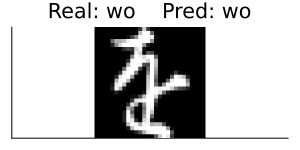

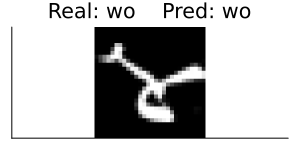

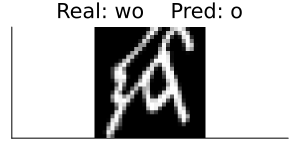

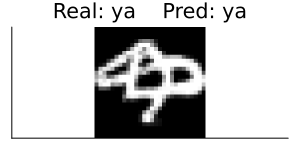

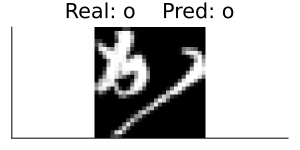

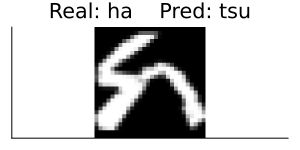

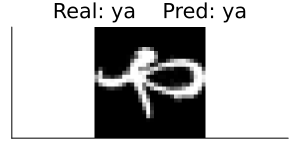

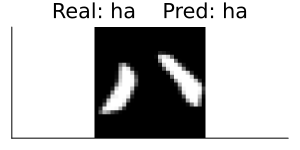

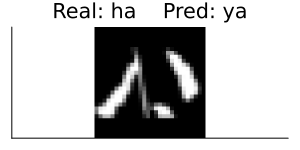

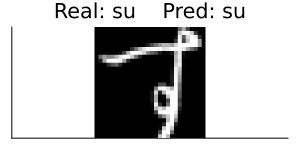

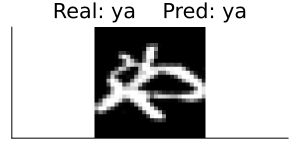

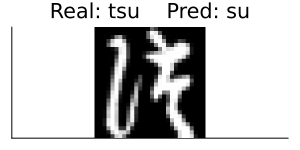

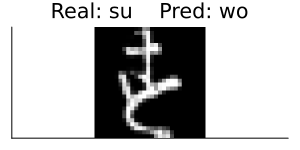

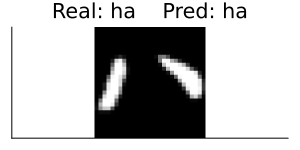

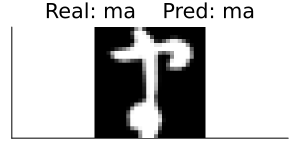

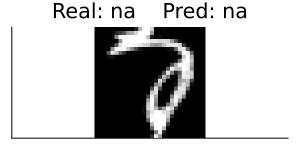

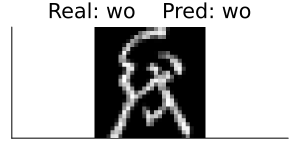

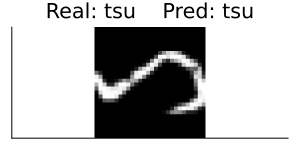

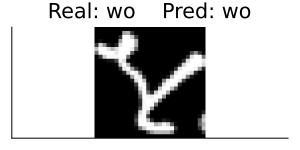

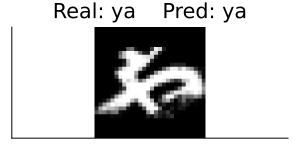

In [35]:
for i in 1:20
    id = rand(1:60000, 1)[1]
    img = train_x[:,:,:,id]
    img_label = [train_y[id]]
    x = Variable(3, img, name="x")
    y = Variable(1, img_label, name="y")
    graph = my_cnn(x, y, cnn_params)
    forward!(graph)
    real_label = labels[img_label[1]+1]
    pred = labels[argmax(graph[19].output)]
    display(plot(Gray.(img[:,:,1]), axis=nothing, size=(300,150), title="Real: $real_label    Pred: $pred"))
end

In [30]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn($x, $y, $graph, $adam, $train_x, $train_y, $test_x, $test_y); #1000

Epoch: 1	Average loss: 0.855	Average acc: 0.739	Average val acc: 0.54
Epoch: 2	Average loss: 0.814	Average acc: 0.758	Average val acc: 0.54
Epoch: 3	Average loss: 0.861	Average acc: 0.73	Average val acc: 0.5
[0.375, 0.375, 0.2, 0.5, 0.571, 0.727, 0.5, 0.462, 0.636, 0.833]
Epoch: 1	Average loss: 0.982	Average acc: 0.701	Average val acc: 0.57
Epoch: 2	Average loss: 0.773	Average acc: 0.762	Average val acc: 0.57
Epoch: 3	Average loss: 0.878	Average acc: 0.716	Average val acc: 0.57
[0.5, 0.4, 0.4, 0.444, 0.4, 0.818, 0.778, 0.385, 0.909, 0.6]
Epoch: 1	Average loss: 1.063	Average acc: 0.697	Average val acc: 0.56
Epoch: 2	Average loss: 0.937	Average acc: 0.734	Average val acc: 0.54
Epoch: 3	Average loss: 0.862	Average acc: 0.748	Average val acc: 0.43
[0.273, 0.167, 0.417, 0.429, 0.4, 0.375, 0.636, 0.636, 0.0, 0.583]
Epoch: 1	Average loss: 1.136	Average acc: 0.687	Average val acc: 0.59
Epoch: 2	Average loss: 0.897	Average acc: 0.73	Average val acc: 0.59
Epoch: 3	Average loss: 0.851	Average acc